<a href="https://colab.research.google.com/github/ItaiKatz1/Random-Forest-implementation/blob/main/Final_Project_Q3_%26_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DISCLAIMER:

Parts of the notebook is inspired by Michael Fire's course - "The Art of Analyzing Big Data- The Data Scientist’s Toolbox".

In [ ]:
!pip install kaggle
!pip install turicreate
!pip install keras-swa
!pip install tensorflow==2.4.1
!pip install keras==2.4.3

     |████████████████████████████████| 92.0MB 107kB/s 
     |████████████████████████████████| 327kB 36.8MB/s 
     |████████████████████████████████| 3.5MB 9.6MB/s 
     |████████████████████████████████| 86.4MB 1.3MB/s 
     |████████████████████████████████| 3.6MB 34.9MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 450kB 38.9MB/s 
     |████████████████████████████████| 3.8MB 38.9MB/s 
     |████████████████████████████████| 2.9MB 44.0MB/s 
     |████████████████████████████████| 18.3MB 1.6MB/s 
  Created wheel for resampy: filename=resampy-0.2.1-cp37-none-any.whl size=320858 sha256=7b0d62caf2a067452578d0a281a1a05ef21d052e339221c3f5ccaa0710d20a48
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
  Created wheel for prettytable: filename=prettytable-0.7.2-cp37-none-any.whl size=13716 sha256=434958fd6c05c6d79db2f210afce7d8beafb26c74c58ed0ca1c299521fca85d2
  Stored in directory

In [ ]:
import pandas as pd

In [ ]:
import json
import os

!mkdir /root/.kaggle/
api_token = {"username":"alongolombek","key":"821d02ac966fc80c16c73b000ac05b29"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir ./datasets/cifar10
!kaggle datasets download joaopauloschuler/cifar10-128x128-resized-via-cai-super-resolution -p ./datasets/cifar10
!unzip ./datasets/cifar10/cifar10-128x128-resized-via-cai-super-resolution.zip  -d ./datasets/cifar10/

Streaming output truncated to the last 5000 lines.
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img1.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img1000.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10030.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10038.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10056.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10071.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10075.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10078.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10080.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10092.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10118.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10123.png  
  inflating: ./datasets/cifar10/cifar10-128/train/class9/img10129.png  
  inflating: ./dat

Import the dataset into a SFrame-type object:

In [ ]:
import turicreate as tc
DATASET_PATH = "./datasets/cifar10/cifar10-128"

train_data = tc.image_analysis.load_images(f"{DATASET_PATH}/train/", with_path=True)
train_data

Read 47464 images in 5.00028 secs	speed: 9492.26 file/sec

path,image
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128


/usr/local/lib/python3.7/dist-packages/turicreate/visualization/_plot.py:461: UserWarning: Displaying only the first 100 rows.
  warnings.warn("Displaying only the first {} rows.".format(maximum_rows))


,path,image
0,/content/datasets/cifar10/cifar10-128/train/class0/img10008.png,
1,/content/datasets/cifar10/cifar10-128/train/class0/img10010.png,
2,/content/datasets/cifar10/cifar10-128/train/class0/img10020.png,
3,/content/datasets/cifar10/cifar10-128/train/class0/img10024.png,
4,/content/datasets/cifar10/cifar10-128/train/class0/img10031.png,
5,/content/datasets/cifar10/cifar10-128/train/class0/img10043.png,
6,/content/datasets/cifar10/cifar10-128/train/class0/img10050.png,
7,/content/datasets/cifar10/cifar10-128/train/class0/img10061.png,
8,/content/datasets/cifar10/cifar10-128/train/class0/img10064.png,
9,/content/datasets/cifar10/cifar10-128/train/class0/img10115.png,

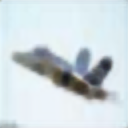
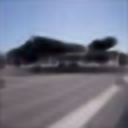
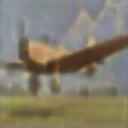
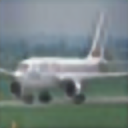
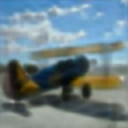
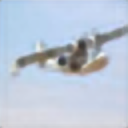
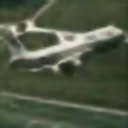
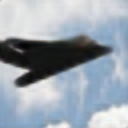
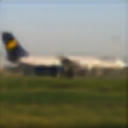
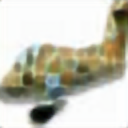
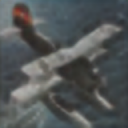
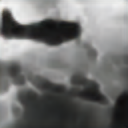
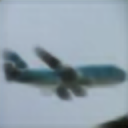
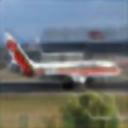
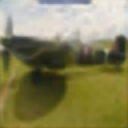
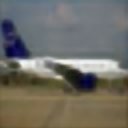
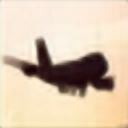
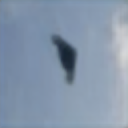
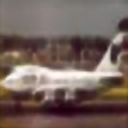
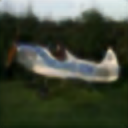
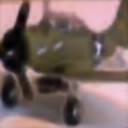
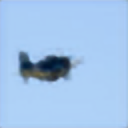
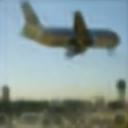
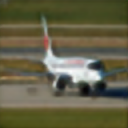
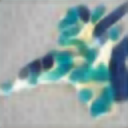
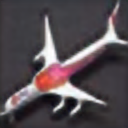
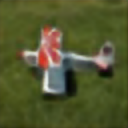
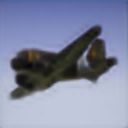
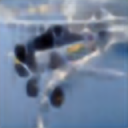
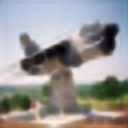
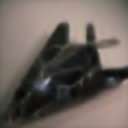
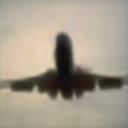
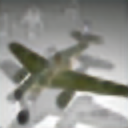
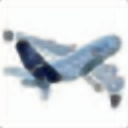
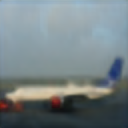
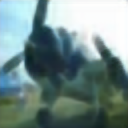
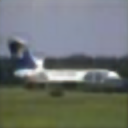
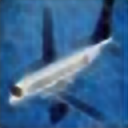
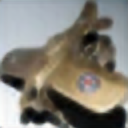
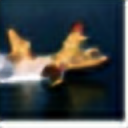
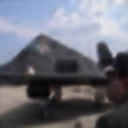
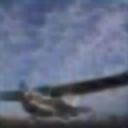
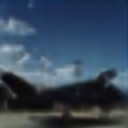
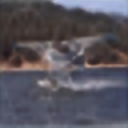
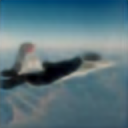
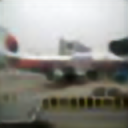
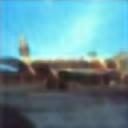
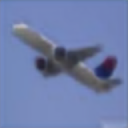
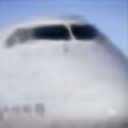
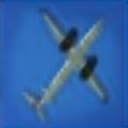
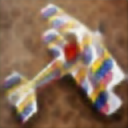
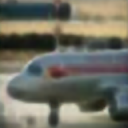
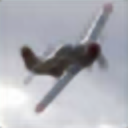
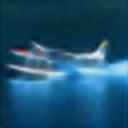
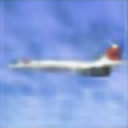
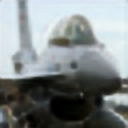
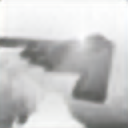
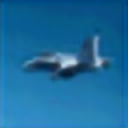
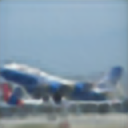
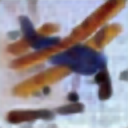
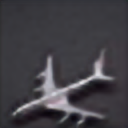
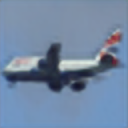
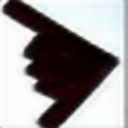
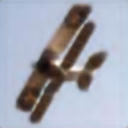
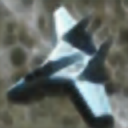
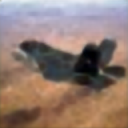
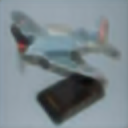
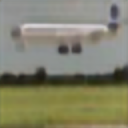
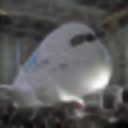
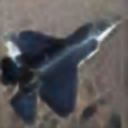
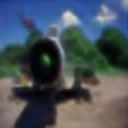
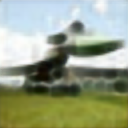
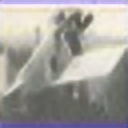
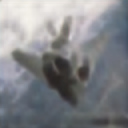
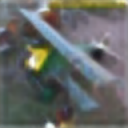
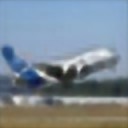
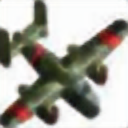
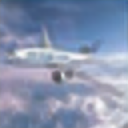
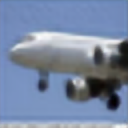
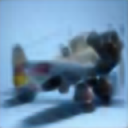
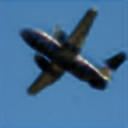
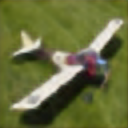
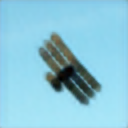
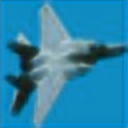
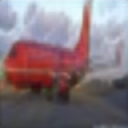
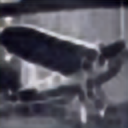
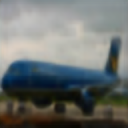
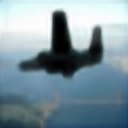
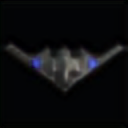
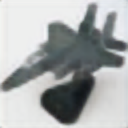
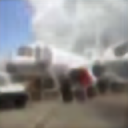
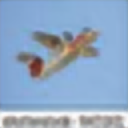
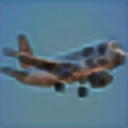
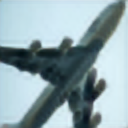
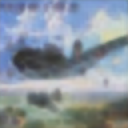
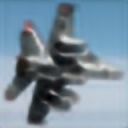
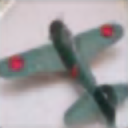
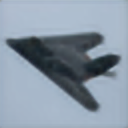
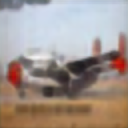
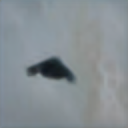

In [ ]:
train_data.explore()

Split the data into train and test sets:

In [ ]:
train_data['class'] = train_data['path'].apply(lambda p: p.split('/')[-2])

In [ ]:
train_data = train_data.sample(.1, seed=5)

In [ ]:
test_data = tc.image_analysis.load_images(f"{DATASET_PATH}/test/", with_path=True)
test_data['class'] = test_data['path'].apply(lambda p: p.split('/')[-2])
test_data.materialize()

Read 4041 images in 5.02268 secs	speed: 804.551 file/sec

Read 7743 images in 10.0227 secs	speed: 740.389 file/sec

In [ ]:
test_data = test_data.sample(.1, seed=5)

In [ ]:
def get_images_features_vector(dataset, target, feature="image", model_name='resnet-50'):
    ptModel = tc.toolkits._pre_trained_models.ResNetImageClassifier()
    feature_extractor = tc.toolkits._image_feature_extractor._create_feature_extractor(model_name)
    extracted_features = tc.SFrame({
        target: dataset[target],
        '__image_features__': feature_extractor.extract_features(dataset, feature),
        })
    dataset['image_features'] = extracted_features['__image_features__']
    return dataset

train_sf = get_images_features_vector(train_data, "class")
test_sf = get_images_features_vector(test_data, "class")
train_sf

Download completed: /var/tmp/model_cache/resnet-50-TuriCreate-6.0.h5


path,image,class,image_features
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.005138438194990158,0.0, 1.2859745025634766, ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.05633961036801338,0.0, 0.18616929650306 ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.01610458455979824,0.0, 0.14849817752838 ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.012200666591525078,0.0, 0.4671143591403961, ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.008841176517307758,0.0, 0.7342517375946045, ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.0007141377427615225,0.0, 0.08769132941961 ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.12261587381362915,0.0, 1.0721834897994995, ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.005276971496641636,0.0, 0.6923959851264954, ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.14945924282073975,0.0, 1.5159027576446533, ..."
/content/datasets/cifar10/cifar10-128/train/cl ...,Height: 128 Width: 128,class0,"[0.02284318022429943,0.0, 0.47520220279693 ..."


Create a Random Forest classifier:

In [ ]:
cls = tc.random_forest_classifier.create(train_sf,target="class", features=["image_features"], max_iterations=50)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Random forest classifier:

--------------------------------------------------------

Number of examples          : 4747

Number of classes           : 10

Number of feature columns   : 1

Number of unpacked features : 2048

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 6.389149     | 0.814620          | 0.584000            | 0.700623          | 1.458506            |

| 2         | 12.778658    | 0.878450          | 0.620000            | 0.561219          | 1.260766            |

| 3         | 19.200009    | 0.907099          | 0.684000            | 0.521873          | 1.146220            |

| 4         | 25.476896    | 0.919739          | 0.680000            | 0.503128          | 1.105817            |

| 5         | 31.865341    | 0.928586          | 0.696000            | 0.488782          | 1.055029            |

| 7         | 44.558195    | 0.939330          | 0.696000            | 0.476511          | 1.032298            |

| 8         | 50.875683    | 0.942911          | 0.708000            | 0.470371          | 1.031744            |

| 9         | 57.147466    | 0.944386          | 0.708000            | 0.466887          | 1.040603            |

| 10        | 63.389299    | 0.945650          | 0.716000            | 0.466412          | 1.023551            |

| 11        | 69.673618    | 0.948810          | 0.736000            | 0.463636          | 1.017828            |

| 12        | 75.949727    | 0.950916          | 0.736000            | 0.461029          | 1.008505            |

| 13        | 82.299926    | 0.951548          | 0.740000            | 0.461526          | 1.001804            |

| 14        | 88.559885    | 0.954076          | 0.756000            | 0.459693          | 0.991828            |

| 15        | 94.803606    | 0.955130          | 0.752000            | 0.458766          | 0.992268            |

| 16        | 101.090854   | 0.954287          | 0.736000            | 0.458323          | 0.992402            |

| 17        | 107.357505   | 0.954287          | 0.740000            | 0.459201          | 0.990842            |

| 18        | 113.685583   | 0.954498          | 0.748000            | 0.458545          | 0.992419            |

| 19        | 120.055858   | 0.953023          | 0.744000            | 0.458407          | 0.990900            |

| 20        | 126.321380   | 0.952812          | 0.748000            | 0.457754          | 0.990827            |

| 21        | 132.664097   | 0.954076          | 0.748000            | 0.457756          | 0.990710            |

| 22        | 138.974647   | 0.953234          | 0.752000            | 0.456913          | 0.986133            |

| 23        | 145.233558   | 0.954076          | 0.768000            | 0.456585          | 0.985075            |

| 24        | 151.511362   | 0.953655          | 0.764000            | 0.456535          | 0.986525            |

| 25        | 157.809929   | 0.954498          | 0.756000            | 0.456104          | 0.985626            |

| 26        | 164.101327   | 0.954919          | 0.752000            | 0.455961          | 0.988189            |

| 27        | 170.306134   | 0.954076          | 0.752000            | 0.455608          | 0.986511            |

| 28        | 176.634001   | 0.953234          | 0.752000            | 0.455344          | 0.985679            |

| 29        | 182.974396   | 0.953444          | 0.756000            | 0.454891          | 0.984108            |

| 30        | 189.338647   | 0.953444          | 0.772000            | 0.454870          | 0.985639            |

| 31        | 195.677904   | 0.953234          | 0.772000            | 0.454315          | 0.984527            |

| 32        | 201.941256   | 0.953444          | 0.764000            | 0.453798          | 0.983722            |

| 33        | 208.205407   | 0.955130          | 0.768000            | 0.453924          | 0.980002            |

| 34        | 214.452206   | 0.955972          | 0.764000            | 0.452714          | 0.977940            |

| 35        | 220.756216   | 0.956183          | 0.768000            | 0.452513          | 0.979950            |

| 36        | 227.017409   | 0.957236          | 0.760000            | 0.452542          | 0.982326            |

| 37        | 233.225747   | 0.955972          | 0.768000            | 0.453282          | 0.985475            |

| 38        | 239.572228   | 0.954708          | 0.760000            | 0.452462          | 0.985268            |

| 39        | 245.977891   | 0.955762          | 0.764000            | 0.451798          | 0.984717            |

| 40        | 252.394002   | 0.954919          | 0.764000            | 0.451539          | 0.985161            |

| 41        | 258.772122   | 0.955762          | 0.764000            | 0.451265          | 0.985035            |

| 42        | 265.029717   | 0.955130          | 0.760000            | 0.451542          | 0.984046            |

| 43        | 271.375004   | 0.955340          | 0.760000            | 0.451702          | 0.983377            |

| 44        | 277.716675   | 0.955130          | 0.760000            | 0.452352          | 0.983748            |

| 45        | 284.078787   | 0.955762          | 0.760000            | 0.452078          | 0.984174            |

| 46        | 290.443650   | 0.955762          | 0.764000            | 0.451925          | 0.982981            |

| 47        | 296.776158   | 0.954287          | 0.752000            | 0.451415          | 0.982024            |

| 48        | 303.126157   | 0.955551          | 0.760000            | 0.450936          | 0.983209            |

| 49        | 309.460787   | 0.955551          | 0.756000            | 0.451113          | 0.984881            |

| 50        | 315.929156   | 0.954708          | 0.756000            | 0.450912          | 0.985127            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

# 20 Datasets - Random Forest (With Hyperparameter Optimization)

In [ ]:
import pandas as pd
import numpy as np
import time
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from numpy import mean
from numpy import std
from sklearn.preprocessing import PolynomialFeatures
import imblearn
# automatic nested cross-validation for random forest on a classification dataset
from sklearn.datasets import make_classification
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import precision_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def complete_nan(df_x, df_y):
    imp_mean = IterativeImputer(max_iter=10, verbose=0, random_state=1)
    imp_mean.fit(df_x, df_y)
    imputed_df = imp_mean.transform(df_x)
    return pd.DataFrame(imputed_df, columns=df_x.columns), imp_mean

In [ ]:
def nested_cross(df, df_results):
    # configure the cross-validation procedure
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    # enumerate splits
    outer_results = list()

    # configure a dictionary to save the best params for each iteration in the nested-cross validation for each classifier
    dict_c = [
        {'classifier': RandomForestClassifier(random_state=1),
         'params': {'n_estimators': [x for x in range(10, 71, 10)], 'max_depth': [2 ** x for x in range(1, 4)]}}
    ]

    # iterate each classifier and extract the best params for the model which gave the highest accuracy
    for m in dict_c:

        max_acc = 0

        cv_index = 0

        for train_ix, test_ix in cv_outer.split(df):

          cv_index += 1
          print('CV Index: {}'.format(cv_index))


          # split data
          X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
          y_train, y_test = df_results.iloc[train_ix], df_results.iloc[test_ix]

          # Use an iterative imputer to fill missing data, returns also the imputer which will will use later for the test set
          X_train,imputer = complete_nan(X_train, y_train)
          # if flag:
          #     X_train = get_new_features(X_train)
          # Generate new neighbours to overcome the oversampling. k=5 is default.

          # configure the cross-validation procedure
          # cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
          cv_inner = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=1)

          # define the model
          model = m['classifier']

          # define search space
          space = m['params']

          # define search
          search = RandomizedSearchCV(model, space, n_iter=50, scoring='f1_macro', n_jobs=4, cv=cv_inner, random_state=1)
          
          # execute search

          start = time.time()
          result = search.fit(X_train, y_train)
          end = time.time()
          print("Training time measure: {}".format(end - start))  
          # get the best performing model fit on the whole training set
          best_model = result.best_estimator_
          # Use the iterative imputer we used on the training to fill missing data in the test set
          imputed_df = imputer.transform(X_test)
          X_test = pd.DataFrame(X_test, columns=X_test.columns)
          # evaluate model on the hold out dataset

          start = time.time()
          yhat = best_model.predict(X_test)
          end = time.time()
          print("Predict time measure: {}".format(end - start)) 

          # evaluate the model
          acc = accuracy_score(y_test, yhat)

          # store the result
          outer_results.append(acc)
          # report progress

          yhat = result.predict(X_test)
          labels = y_test.unique()
          # Binarize ytest with shape (n_samples, n_classes)
          ytest = label_binarize(y_test, classes=labels)
          # Binarize ypreds with shape (n_samples, n_classes)
          ypreds = label_binarize(yhat, classes=labels)

          cnf_matrix = confusion_matrix(y_test, yhat)
          FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
          FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
          TP = np.diag(cnf_matrix)
          TN = cnf_matrix.sum() - (FP + FN + TP)
          FP = FP.astype(float)
          FN = FN.astype(float)
          TP = TP.astype(float)
          TN = TN.astype(float)
          TPR = TP/(TP+FN)
          FPR = FP/(FP+TN)
          pr_curve_auc = average_precision_score(ytest, ypreds)
          precision = precision_score(y_test, yhat,average='macro')
          roc_auc = roc_auc_score(ytest, ypreds,multi_class='ovo',average='macro')
          print('>acc=%.3f, est=%.3f, prec=%.3f, cfg=%s' % (acc, result.best_score_,precision, result.best_params_))
          print('>ROC_Auc=%.3f, PR_Curve_Auc=%.3f, FPR=%.3f, TPR=%.3f' % (roc_auc, pr_curve_auc, np.mean(FPR), np.mean(TPR)))
          print()

        # summarize the estimated performance of the model
        print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
        print()

    return dict_c

In [ ]:
def get_results(clf, X_train, y_train, X_test, y_test):
    result = clf.fit(X_train, y_train)

    yhat = result.predict(X_test)
    labels = y_test.unique()
    # Binarize ytest with shape (n_samples, n_classes)
    ytest = label_binarize(y_test, classes=labels)
    # Binarize ypreds with shape (n_samples, n_classes)
    ypreds = label_binarize(yhat, classes=labels)

    cnf_matrix = confusion_matrix(y_test, yhat)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    FNR = FN/(TP+FN)
    

    pr_curve_auc = average_precision_score(ytest, ypreds)

    # evaluate the model
    return accuracy_score(y_test, yhat), roc_auc_score(ytest, ypreds,multi_class='ovo',average='macro'),pr_curve_auc, FPR, TPR


## 1. Abalon

In [ ]:
!gdown --id 1IEq4AA_EwBoLE0JXcBNwKpta8Eti8pXE

Downloading...
From: https://drive.google.com/uc?id=1IEq4AA_EwBoLE0JXcBNwKpta8Eti8pXE
To: /content/abalon.csv
100% 318k/318k [00:00<00:00, 21.4MB/s]


In [ ]:
df = pd.read_csv("/content/abalon.csv")
df_results = df['class']
df = df.drop(columns='class')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 31.03734588623047
Predict time measure: 0.0031342506408691406
>acc=0.620, est=0.649, prec=0.619, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.717, PR_Curve_Auc=0.529, FPR=0.192, TPR=0.626

CV Index: 2
Training time measure: 28.655348300933838
Predict time measure: 0.003359556198120117
>acc=0.670, est=0.647, prec=0.666, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.751, PR_Curve_Auc=0.562, FPR=0.164, TPR=0.665

CV Index: 3
Training time measure: 28.48981785774231
Predict time measure: 0.003068685531616211
>acc=0.660, est=0.645, prec=0.658, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.746, PR_Curve_Auc=0.559, FPR=0.170, TPR=0.661

CV Index: 4
Training time measure: 28.465783834457397
Predict time measure: 0.0032129287719726562
>acc=0.617, est=0.647, prec=0.606, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.714, PR_Curve_Auc=0.520, FPR=0.191, TPR=0.619

CV Index: 5
Training time measure: 29.332170248031616
Predict time measure: 

## 2. Steel-Plates

In [ ]:
!gdown --id 1lf5bW87jOgFjMBjbOIHolHUFgGsP2EdA

Downloading...
From: https://drive.google.com/uc?id=1lf5bW87jOgFjMBjbOIHolHUFgGsP2EdA
To: /content/steel-plates.csv
100% 492k/492k [00:00<00:00, 7.86MB/s]


In [ ]:
df = pd.read_csv("/content/steel-plates.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 56.23263144493103
Predict time measure: 0.0072612762451171875
>acc=0.769, est=0.760, prec=0.827, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.847, PR_Curve_Auc=0.662, FPR=0.046, TPR=0.741

CV Index: 2


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 54.157203674316406
Predict time measure: 0.005682945251464844
>acc=0.732, est=0.740, prec=0.835, cfg={'n_estimators': 50, 'max_depth': 8}
>ROC_Auc=0.844, PR_Curve_Auc=0.684, FPR=0.055, TPR=0.743

CV Index: 3


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 53.263596057891846
Predict time measure: 0.005567073822021484
>acc=0.722, est=0.756, prec=0.864, cfg={'n_estimators': 50, 'max_depth': 8}
>ROC_Auc=0.804, PR_Curve_Auc=0.621, FPR=0.059, TPR=0.667

CV Index: 4


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 53.566288471221924
Predict time measure: 0.006429910659790039
>acc=0.773, est=0.736, prec=0.778, cfg={'n_estimators': 60, 'max_depth': 8}
>ROC_Auc=0.866, PR_Curve_Auc=0.655, FPR=0.042, TPR=0.775

CV Index: 5


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 53.07337498664856
Predict time measure: 0.007244110107421875
>acc=0.706, est=0.749, prec=0.820, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.809, PR_Curve_Auc=0.611, FPR=0.059, TPR=0.678

CV Index: 6


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 53.358590602874756
Predict time measure: 0.014419078826904297
>acc=0.768, est=0.745, prec=0.818, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.849, PR_Curve_Auc=0.658, FPR=0.045, TPR=0.743

CV Index: 7


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 55.09913921356201
Predict time measure: 0.004748106002807617
>acc=0.722, est=0.735, prec=0.869, cfg={'n_estimators': 30, 'max_depth': 8}
>ROC_Auc=0.832, PR_Curve_Auc=0.661, FPR=0.055, TPR=0.719

CV Index: 8


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 57.442012310028076
Predict time measure: 0.007770061492919922
>acc=0.768, est=0.747, prec=0.834, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.847, PR_Curve_Auc=0.665, FPR=0.046, TPR=0.740

CV Index: 9


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 54.72930693626404
Predict time measure: 0.008024215698242188
>acc=0.742, est=0.759, prec=0.762, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.814, PR_Curve_Auc=0.567, FPR=0.052, TPR=0.679

CV Index: 10


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 52.77222728729248
Predict time measure: 0.013332605361938477
>acc=0.768, est=0.752, prec=0.800, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.847, PR_Curve_Auc=0.633, FPR=0.047, TPR=0.742

Accuracy: 0.747 (0.024)



## 3. Hill-Valley

In [ ]:
!gdown --id 1oItZMkmno_26L7Omfhg-s-fZvtCGWCD9

Downloading...
From: https://drive.google.com/uc?id=1oItZMkmno_26L7Omfhg-s-fZvtCGWCD9
To: /content/hill-valley.csv
100% 991k/991k [00:00<00:00, 15.6MB/s]


In [ ]:
df = pd.read_csv("/content/hill-valley.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 34.91998815536499
Predict time measure: 0.0024039745330810547
>acc=0.508, est=0.509, prec=0.508, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.508, PR_Curve_Auc=0.496, FPR=0.492, TPR=0.508

CV Index: 2
Training time measure: 34.48163843154907
Predict time measure: 0.0024251937866210938
>acc=0.467, est=0.518, prec=0.470, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.470, PR_Curve_Auc=0.527, FPR=0.530, TPR=0.470

CV Index: 3
Training time measure: 34.69442820549011
Predict time measure: 0.003999948501586914
>acc=0.512, est=0.514, prec=0.516, cfg={'n_estimators': 40, 'max_depth': 4}
>ROC_Auc=0.516, PR_Curve_Auc=0.488, FPR=0.484, TPR=0.516

CV Index: 4
Training time measure: 34.66961073875427
Predict time measure: 0.002483367919921875
>acc=0.479, est=0.508, prec=0.478, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.478, PR_Curve_Auc=0.527, FPR=0.522, TPR=0.478

CV Index: 5
Training time measure: 34.82218837738037
Predict time measure: 0.0

## 4. Wall Following

In [ ]:
!gdown --id 1g4FWvO9tJsd1WhueT95vujBPwex7vDn1

Downloading...
From: https://drive.google.com/uc?id=1g4FWvO9tJsd1WhueT95vujBPwex7vDn1
To: /content/wall-following.csv
100% 1.25M/1.25M [00:00<00:00, 19.8MB/s]


In [ ]:
df = pd.read_csv("/content/wall-following.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 47.464131116867065
Predict time measure: 0.003204345703125
>acc=0.989, est=0.980, prec=0.993, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.985, PR_Curve_Auc=0.969, FPR=0.004, TPR=0.973

CV Index: 2
Training time measure: 47.61363887786865
Predict time measure: 0.0032052993774414062
>acc=0.984, est=0.979, prec=0.983, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.985, PR_Curve_Auc=0.963, FPR=0.006, TPR=0.976

CV Index: 3
Training time measure: 47.49727392196655
Predict time measure: 0.0032072067260742188
>acc=0.995, est=0.980, prec=0.986, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.996, PR_Curve_Auc=0.982, FPR=0.002, TPR=0.995

CV Index: 4
Training time measure: 47.85078454017639
Predict time measure: 0.0033431053161621094
>acc=0.993, est=0.978, prec=0.995, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.991, PR_Curve_Auc=0.982, FPR=0.003, TPR=0.985

CV Index: 5
Training time measure: 47.6933319568634
Predict time measure: 0.003

## 5. Plant Texture

In [ ]:
!gdown --id 10jOUBLfZKBH5tHzz8QMmwnt12v791eEP

Downloading...
From: https://drive.google.com/uc?id=10jOUBLfZKBH5tHzz8QMmwnt12v791eEP
To: /content/plant-texture.csv
100% 984k/984k [00:00<00:00, 15.6MB/s]


In [ ]:
df = pd.read_csv("/content/plant-texture.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 37.192238092422485
Predict time measure: 0.0035936832427978516
>acc=0.537, est=0.502, prec=0.467, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.779, PR_Curve_Auc=0.439, FPR=0.005, TPR=nan

CV Index: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.19627404212952
Predict time measure: 0.00341796875
>acc=0.600, est=0.501, prec=0.495, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.796, PR_Curve_Auc=0.463, FPR=0.005, TPR=nan

CV Index: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.19692611694336
Predict time measure: 0.0037908554077148438
>acc=0.606, est=0.516, prec=0.510, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.807, PR_Curve_Auc=0.497, FPR=0.004, TPR=nan

CV Index: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.43670392036438
Predict time measure: 0.003299713134765625
>acc=0.481, est=0.496, prec=0.368, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.738, PR_Curve_Auc=0.345, FPR=0.006, TPR=nan

CV Index: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 36.909894704818726
Predict time measure: 0.0034885406494140625
>acc=0.556, est=0.478, prec=0.464, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.780, PR_Curve_Auc=0.419, FPR=0.005, TPR=nan

CV Index: 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.32369017601013
Predict time measure: 0.003388643264770508
>acc=0.544, est=0.489, prec=0.502, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.784, PR_Curve_Auc=0.464, FPR=0.005, TPR=nan

CV Index: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.09817290306091
Predict time measure: 0.003436565399169922
>acc=0.544, est=0.490, prec=0.476, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.780, PR_Curve_Auc=0.449, FPR=0.005, TPR=nan

CV Index: 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.02053093910217
Predict time measure: 0.003549814224243164
>acc=0.562, est=0.514, prec=0.517, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.797, PR_Curve_Auc=0.464, FPR=0.005, TPR=nan

CV Index: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 37.149837493896484
Predict time measure: 0.0034825801849365234
>acc=0.606, est=0.495, prec=0.534, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.811, PR_Curve_Auc=0.486, FPR=0.004, TPR=nan

CV Index: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 36.37818241119385
Predict time measure: 0.003415346145629883
>acc=0.623, est=0.509, prec=0.515, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.812, PR_Curve_Auc=0.496, FPR=0.004, TPR=nan

Accuracy: 0.566 (0.041)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6. Statlog-Image

In [ ]:
!gdown --id 1aqriZGbmwn87hGkjUbUtiYYwmmcIqKbH

Downloading...
From: https://drive.google.com/uc?id=1aqriZGbmwn87hGkjUbUtiYYwmmcIqKbH
To: /content/statlog-image.csv
100% 397k/397k [00:00<00:00, 9.84MB/s]


In [ ]:
df = pd.read_csv("/content/statlog-image.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 53.376972675323486
Predict time measure: 0.007382631301879883
>acc=0.978, est=0.961, prec=0.978, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.984, PR_Curve_Auc=0.954, FPR=0.004, TPR=0.972

CV Index: 2


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 51.11281490325928
Predict time measure: 0.007202625274658203
>acc=0.948, est=0.965, prec=0.948, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.967, PR_Curve_Auc=0.903, FPR=0.009, TPR=0.943

CV Index: 3


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 51.09819149971008
Predict time measure: 0.0063626766204833984
>acc=0.978, est=0.964, prec=0.979, cfg={'n_estimators': 60, 'max_depth': 8}
>ROC_Auc=0.987, PR_Curve_Auc=0.961, FPR=0.004, TPR=0.978

CV Index: 4


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 50.81651568412781
Predict time measure: 0.006860971450805664
>acc=0.931, est=0.966, prec=0.937, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.964, PR_Curve_Auc=0.895, FPR=0.012, TPR=0.940

CV Index: 5


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 50.520288944244385
Predict time measure: 0.007617473602294922
>acc=0.978, est=0.961, prec=0.979, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.988, PR_Curve_Auc=0.963, FPR=0.004, TPR=0.980

CV Index: 6


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 51.59057545661926
Predict time measure: 0.007407188415527344
>acc=0.952, est=0.966, prec=0.954, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.973, PR_Curve_Auc=0.919, FPR=0.008, TPR=0.953

CV Index: 7


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 51.50790095329285
Predict time measure: 0.0070188045501708984
>acc=0.974, est=0.965, prec=0.970, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.985, PR_Curve_Auc=0.948, FPR=0.004, TPR=0.973

CV Index: 8


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 49.05453014373779
Predict time measure: 0.006720304489135742
>acc=0.961, est=0.965, prec=0.961, cfg={'n_estimators': 60, 'max_depth': 8}
>ROC_Auc=0.979, PR_Curve_Auc=0.932, FPR=0.007, TPR=0.964

CV Index: 9


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 49.676809310913086
Predict time measure: 0.00825047492980957
>acc=0.987, est=0.964, prec=0.987, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.991, PR_Curve_Auc=0.972, FPR=0.002, TPR=0.984

CV Index: 10


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 21 is smaller than n_iter=50. Running 21 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Training time measure: 50.9407320022583
Predict time measure: 0.007005929946899414
>acc=0.944, est=0.966, prec=0.949, cfg={'n_estimators': 70, 'max_depth': 8}
>ROC_Auc=0.970, PR_Curve_Auc=0.910, FPR=0.010, TPR=0.949

Accuracy: 0.963 (0.018)



## 7. Bank

In [ ]:
!gdown --id 1phMW90m7COEGuHTnL7U5SFGwVBctdKtz

Downloading...
From: https://drive.google.com/uc?id=1phMW90m7COEGuHTnL7U5SFGwVBctdKtz
To: /content/bank.csv
100% 689k/689k [00:00<00:00, 10.8MB/s]


In [ ]:
df = pd.read_csv("/content/bank.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 29.053024530410767
Predict time measure: 0.002910137176513672
>acc=0.890, est=0.658, prec=0.746, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.647, PR_Curve_Auc=0.911, FPR=0.353, TPR=0.647

CV Index: 2
Training time measure: 28.84991478919983
Predict time measure: 0.0030488967895507812
>acc=0.874, est=0.660, prec=0.730, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.589, PR_Curve_Auc=0.220, FPR=0.411, TPR=0.589

CV Index: 3
Training time measure: 29.063827753067017
Predict time measure: 0.003233194351196289
>acc=0.889, est=0.643, prec=0.823, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.619, PR_Curve_Auc=0.287, FPR=0.381, TPR=0.619

CV Index: 4
Training time measure: 29.065547227859497
Predict time measure: 0.0032372474670410156
>acc=0.929, est=0.655, prec=0.802, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.606, PR_Curve_Auc=0.210, FPR=0.394, TPR=0.606

CV Index: 5
Training time measure: 28.394034385681152
Predict time measure:

## 8. Ozone

In [ ]:
!gdown --id 1nGv568O32v1nR5qz8wybZtIi8FCpkKlQ

Downloading...
From: https://drive.google.com/uc?id=1nGv568O32v1nR5qz8wybZtIi8FCpkKlQ
To: /content/ozone.csv
100% 1.67M/1.67M [00:00<00:00, 26.5MB/s]


In [ ]:
df = pd.read_csv("/content/ozone.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 34.99980902671814
Predict time measure: 0.0025970935821533203
>acc=0.972, est=0.502, prec=0.486, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.500, PR_Curve_Auc=0.028, FPR=0.500, TPR=0.500

CV Index: 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.5241961479187
Predict time measure: 0.0025534629821777344
>acc=0.957, est=0.505, prec=0.978, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.542, PR_Curve_Auc=0.127, FPR=0.458, TPR=0.542

CV Index: 3
Training time measure: 35.04797911643982
Predict time measure: 0.0026187896728515625
>acc=0.984, est=0.516, prec=0.492, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.500, PR_Curve_Auc=0.016, FPR=0.500, TPR=0.500

CV Index: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.27196455001831
Predict time measure: 0.0026831626892089844
>acc=0.965, est=0.521, prec=0.484, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.498, PR_Curve_Auc=0.031, FPR=0.502, TPR=0.498

CV Index: 5
Training time measure: 34.33221960067749
Predict time measure: 0.0027039051055908203
>acc=0.969, est=0.500, prec=0.484, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.500, PR_Curve_Auc=0.031, FPR=0.500, TPR=0.500

CV Index: 6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.2727210521698
Predict time measure: 0.002635955810546875
>acc=0.965, est=0.512, prec=0.734, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.554, PR_Curve_Auc=0.087, FPR=0.446, TPR=0.554

CV Index: 7
Training time measure: 33.685446977615356
Predict time measure: 0.004670858383178711
>acc=0.964, est=0.514, prec=0.482, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.500, PR_Curve_Auc=0.036, FPR=0.500, TPR=0.500

CV Index: 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.71296548843384
Predict time measure: 0.005218029022216797
>acc=0.988, est=0.511, prec=0.494, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.500, PR_Curve_Auc=0.012, FPR=0.500, TPR=0.500

CV Index: 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.67851996421814
Predict time measure: 0.0026013851165771484
>acc=0.976, est=0.505, prec=0.740, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.581, PR_Curve_Auc=0.103, FPR=0.419, TPR=0.581

CV Index: 10
Training time measure: 33.88863801956177
Predict time measure: 0.002536773681640625
>acc=0.968, est=0.512, prec=0.486, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.498, PR_Curve_Auc=0.028, FPR=0.502, TPR=0.498

Accuracy: 0.971 (0.009)



## 9. Wine-Quality White

In [ ]:
!gdown --id 1AjE7qVvpnuqS0OLON-_yBL1hPqfGgGGJ

Downloading...
From: https://drive.google.com/uc?id=1AjE7qVvpnuqS0OLON-_yBL1hPqfGgGGJ
To: /content/wine-quality-white.csv
100% 514k/514k [00:00<00:00, 8.11MB/s]


In [ ]:
df = pd.read_csv("/content/wine-quality-white.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 34.63408660888672
Predict time measure: 0.003459930419921875
>acc=0.592, est=0.271, prec=0.767, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.608, PR_Curve_Auc=0.305, FPR=0.139, TPR=0.354

CV Index: 2
Training time measure: 34.732765197753906
Predict time measure: 0.0035750865936279297
>acc=0.578, est=0.273, prec=0.458, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.590, PR_Curve_Auc=0.244, FPR=0.113, TPR=0.293

CV Index: 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.74333906173706
Predict time measure: 0.003544330596923828
>acc=0.624, est=0.273, prec=0.339, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.595, PR_Curve_Auc=0.256, FPR=0.106, TPR=0.296

CV Index: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.24886107444763
Predict time measure: 0.0034677982330322266
>acc=0.604, est=0.262, prec=0.485, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.609, PR_Curve_Auc=0.280, FPR=0.106, TPR=0.325

CV Index: 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.8168158531189
Predict time measure: 0.0034329891204833984
>acc=0.616, est=0.266, prec=0.515, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.597, PR_Curve_Auc=0.240, FPR=0.091, TPR=0.286

CV Index: 6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.83188557624817
Predict time measure: 0.0033473968505859375
>acc=0.627, est=0.268, prec=0.435, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.589, PR_Curve_Auc=0.233, FPR=0.089, TPR=0.267

CV Index: 7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.84131836891174
Predict time measure: 0.00342559814453125
>acc=0.551, est=0.278, prec=0.236, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.567, PR_Curve_Auc=0.196, FPR=0.104, TPR=0.239

CV Index: 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.69625282287598
Predict time measure: 0.0034067630767822266
>acc=0.582, est=0.275, prec=0.380, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.573, PR_Curve_Auc=0.203, FPR=0.101, TPR=0.248

CV Index: 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.17619299888611
Predict time measure: 0.0034317970275878906
>acc=0.595, est=0.262, prec=0.631, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.600, PR_Curve_Auc=0.263, FPR=0.112, TPR=0.312

CV Index: 10


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 34.587101221084595
Predict time measure: 0.0033571720123291016
>acc=0.564, est=0.277, prec=0.405, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.586, PR_Curve_Auc=0.243, FPR=0.122, TPR=0.294

Accuracy: 0.593 (0.024)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 10. Waveform

In [ ]:
!gdown --id 1GusRPo1MDhxZcWxtQh3Pd7azP1VBWaQ6

Downloading...
From: https://drive.google.com/uc?id=1GusRPo1MDhxZcWxtQh3Pd7azP1VBWaQ6
To: /content/waveform.csv
100% 975k/975k [00:00<00:00, 15.3MB/s]


In [ ]:
df = pd.read_csv("/content/waveform.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 48.83693170547485
Predict time measure: 0.003326892852783203
>acc=0.856, est=0.835, prec=0.858, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.892, PR_Curve_Auc=0.783, FPR=0.072, TPR=0.857

CV Index: 2
Training time measure: 48.69951033592224
Predict time measure: 0.0033774375915527344
>acc=0.846, est=0.837, prec=0.844, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.882, PR_Curve_Auc=0.762, FPR=0.077, TPR=0.842

CV Index: 3
Training time measure: 48.64933729171753
Predict time measure: 0.0034503936767578125
>acc=0.874, est=0.836, prec=0.873, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.905, PR_Curve_Auc=0.804, FPR=0.063, TPR=0.872

CV Index: 4
Training time measure: 50.4229621887207
Predict time measure: 0.0033838748931884766
>acc=0.832, est=0.837, prec=0.833, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.875, PR_Curve_Auc=0.749, FPR=0.084, TPR=0.833

CV Index: 5
Training time measure: 49.90701413154602
Predict time measure: 0.0

## 11. Chess-krvkp

In [ ]:
!gdown --id 1PGZ990mCf0Z1-Mcq01q7Z5QQKZqWWxFX

Downloading...
From: https://drive.google.com/uc?id=1PGZ990mCf0Z1-Mcq01q7Z5QQKZqWWxFX
To: /content/chess-krvkp.csv
100% 1.11M/1.11M [00:00<00:00, 17.6MB/s]


In [ ]:
df = pd.read_csv("/content/chess-krvkp.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 22.459962606430054
Predict time measure: 0.002694368362426758
>acc=0.959, est=0.957, prec=0.961, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.958, PR_Curve_Auc=0.947, FPR=0.042, TPR=0.958

CV Index: 2
Training time measure: 22.607264757156372
Predict time measure: 0.0028464794158935547
>acc=0.963, est=0.960, prec=0.964, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.961, PR_Curve_Auc=0.948, FPR=0.039, TPR=0.961

CV Index: 3
Training time measure: 22.393556356430054
Predict time measure: 0.003151416778564453
>acc=0.972, est=0.961, prec=0.972, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.972, PR_Curve_Auc=0.957, FPR=0.028, TPR=0.972

CV Index: 4
Training time measure: 22.81955623626709
Predict time measure: 0.0027637481689453125
>acc=0.963, est=0.961, prec=0.963, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.962, PR_Curve_Auc=0.943, FPR=0.038, TPR=0.962

CV Index: 5
Training time measure: 22.79208755493164
Predict time measure: 

## 12. Plant Margin

In [ ]:
!gdown --id 18qh_P_lzhvXi5m73vqUy8GXEm9gLAZta

Downloading...
From: https://drive.google.com/uc?id=18qh_P_lzhvXi5m73vqUy8GXEm9gLAZta
To: /content/plant-margin.csv
100% 971k/971k [00:00<00:00, 15.3MB/s]


In [ ]:
df = pd.read_csv("/content/plant-margin.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 33.31575894355774
Predict time measure: 0.0036704540252685547
>acc=0.556, est=0.535, prec=0.471, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.787, PR_Curve_Auc=0.446, FPR=0.005, TPR=nan

CV Index: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 33.74606895446777
Predict time measure: 0.003549814224243164
>acc=0.556, est=0.528, prec=0.464, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.788, PR_Curve_Auc=0.435, FPR=0.005, TPR=nan

CV Index: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 33.55669403076172
Predict time measure: 0.006326198577880859
>acc=0.600, est=0.511, prec=0.570, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.819, PR_Curve_Auc=0.532, FPR=0.004, TPR=nan

CV Index: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 33.32620358467102
Predict time measure: 0.0035200119018554688
>acc=0.575, est=0.521, prec=0.549, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.808, PR_Curve_Auc=0.528, FPR=0.005, TPR=nan

CV Index: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 33.014543294906616
Predict time measure: 0.003471851348876953
>acc=0.581, est=0.526, prec=0.510, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.796, PR_Curve_Auc=0.459, FPR=0.005, TPR=nan

CV Index: 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 32.94193983078003
Predict time measure: 0.003489971160888672
>acc=0.550, est=0.524, prec=0.479, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.791, PR_Curve_Auc=0.439, FPR=0.005, TPR=nan

CV Index: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 32.25583457946777
Predict time measure: 0.0034279823303222656
>acc=0.594, est=0.519, prec=0.533, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.805, PR_Curve_Auc=0.481, FPR=0.005, TPR=nan

CV Index: 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 32.3350145816803
Predict time measure: 0.003444194793701172
>acc=0.506, est=0.515, prec=0.438, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.793, PR_Curve_Auc=0.446, FPR=0.005, TPR=nan

CV Index: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 31.68563199043274
Predict time measure: 0.003988742828369141
>acc=0.600, est=0.522, prec=0.582, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.813, PR_Curve_Auc=0.514, FPR=0.004, TPR=nan

CV Index: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 32.15634846687317
Predict time measure: 0.0035250186920166016
>acc=0.537, est=0.526, prec=0.447, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.770, PR_Curve_Auc=0.415, FPR=0.005, TPR=nan

Accuracy: 0.566 (0.029)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 13. Plant Shape

In [ ]:
!gdown --id 1TdVJw_Axu-uDG2gGHjYf6giae8-h0xCd

Downloading...
From: https://drive.google.com/uc?id=1TdVJw_Axu-uDG2gGHjYf6giae8-h0xCd
To: /content/plant-shape.csv
100% 962k/962k [00:00<00:00, 31.0MB/s]


In [ ]:
df = pd.read_csv("/content/plant-shape.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 75.60562634468079
Predict time measure: 0.004599094390869141
>acc=0.450, est=0.460, prec=0.417, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.741, PR_Curve_Auc=0.349, FPR=0.006, TPR=nan

CV Index: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 75.74084329605103
Predict time measure: 0.0036857128143310547
>acc=0.431, est=0.448, prec=0.356, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.725, PR_Curve_Auc=0.334, FPR=0.006, TPR=nan

CV Index: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 77.12449240684509
Predict time measure: 0.003721952438354492
>acc=0.531, est=0.445, prec=0.455, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.761, PR_Curve_Auc=0.441, FPR=0.005, TPR=nan

CV Index: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 75.28932857513428
Predict time measure: 0.003572225570678711
>acc=0.537, est=0.440, prec=0.447, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.760, PR_Curve_Auc=0.402, FPR=0.005, TPR=nan

CV Index: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 75.12503957748413
Predict time measure: 0.0038061141967773438
>acc=0.475, est=0.447, prec=0.379, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.721, PR_Curve_Auc=0.330, FPR=0.006, TPR=nan

CV Index: 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 74.59576463699341
Predict time measure: 0.0037987232208251953
>acc=0.500, est=0.449, prec=0.390, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.754, PR_Curve_Auc=0.386, FPR=0.005, TPR=nan

CV Index: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 75.02932214736938
Predict time measure: 0.0035228729248046875
>acc=0.456, est=0.442, prec=0.402, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.742, PR_Curve_Auc=0.383, FPR=0.006, TPR=nan

CV Index: 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 75.37832617759705
Predict time measure: 0.003648519515991211
>acc=0.469, est=0.449, prec=0.447, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.745, PR_Curve_Auc=0.398, FPR=0.006, TPR=nan

CV Index: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 74.59893774986267
Predict time measure: 0.0035665035247802734
>acc=0.475, est=0.443, prec=0.443, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.749, PR_Curve_Auc=0.379, FPR=0.006, TPR=nan

CV Index: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training time measure: 75.10501289367676
Predict time measure: 0.00536656379699707
>acc=0.512, est=0.449, prec=0.442, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.786, PR_Curve_Auc=0.439, FPR=0.005, TPR=nan

Accuracy: 0.484 (0.034)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 14. Musk-1

In [ ]:
!gdown --id 1CSlfAdBKOc44jo3G5xrqrX96xMQGlo-G

Downloading...
From: https://drive.google.com/uc?id=1CSlfAdBKOc44jo3G5xrqrX96xMQGlo-G
To: /content/musk-1.csv
100% 727k/727k [00:00<00:00, 11.5MB/s]


In [ ]:
df = pd.read_csv("/content/musk-1.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 22.71639370918274
Predict time measure: 0.002326488494873047
>acc=0.875, est=0.844, prec=0.873, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.878, PR_Curve_Auc=0.867, FPR=0.122, TPR=0.878

CV Index: 2
Training time measure: 22.63092279434204
Predict time measure: 0.0022656917572021484
>acc=0.917, est=0.850, prec=0.896, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.921, PR_Curve_Auc=0.942, FPR=0.079, TPR=0.921

CV Index: 3
Training time measure: 22.73308825492859
Predict time measure: 0.0023293495178222656
>acc=0.833, est=0.851, prec=0.829, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.829, PR_Curve_Auc=0.818, FPR=0.171, TPR=0.829

CV Index: 4
Training time measure: 22.74268364906311
Predict time measure: 0.002384185791015625
>acc=0.938, est=0.837, prec=0.939, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.935, PR_Curve_Auc=0.911, FPR=0.065, TPR=0.935

CV Index: 5
Training time measure: 22.856375455856323
Predict time measure: 0.

## 15. Semieon

In [ ]:
!gdown --id 1QpKJyvF0Gj4EcKbj8sPYETx2Oi_V9YOC

Downloading...
From: https://drive.google.com/uc?id=1QpKJyvF0Gj4EcKbj8sPYETx2Oi_V9YOC
To: /content/semeion.csv
3.77MB [00:00, 33.3MB/s]


In [ ]:
df = pd.read_csv("/content/semeion.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 24.01779317855835
Predict time measure: 0.0028493404388427734
>acc=0.881, est=0.891, prec=0.883, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.931, PR_Curve_Auc=0.790, FPR=0.013, TPR=0.875

CV Index: 2
Training time measure: 24.219207286834717
Predict time measure: 0.0029096603393554688
>acc=0.887, est=0.883, prec=0.894, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.943, PR_Curve_Auc=0.816, FPR=0.013, TPR=0.899

CV Index: 3
Training time measure: 24.259793996810913
Predict time measure: 0.0028433799743652344
>acc=0.912, est=0.884, prec=0.910, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.949, PR_Curve_Auc=0.836, FPR=0.010, TPR=0.908

CV Index: 4
Training time measure: 24.176429510116577
Predict time measure: 0.002973318099975586
>acc=0.881, est=0.888, prec=0.882, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.933, PR_Curve_Auc=0.785, FPR=0.013, TPR=0.878

CV Index: 5
Training time measure: 23.967211484909058
Predict time measure

## 16. Spambase

In [ ]:
!gdown --id 11gcORtu9jjkb0OVkakgOhJ5sK_qhOtz-

Downloading...
From: https://drive.google.com/uc?id=11gcORtu9jjkb0OVkakgOhJ5sK_qhOtz-
To: /content/spambase.csv
2.59MB [00:00, 41.1MB/s]


In [ ]:
df = pd.read_csv("/content/spambase.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 32.03589105606079
Predict time measure: 0.0030477046966552734
>acc=0.959, est=0.930, prec=0.960, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.954, PR_Curve_Auc=0.947, FPR=0.046, TPR=0.954

CV Index: 2
Training time measure: 32.4280526638031
Predict time measure: 0.003154754638671875
>acc=0.937, est=0.930, prec=0.941, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.924, PR_Curve_Auc=0.920, FPR=0.076, TPR=0.924

CV Index: 3
Training time measure: 32.50016665458679
Predict time measure: 0.0029828548431396484
>acc=0.924, est=0.931, prec=0.927, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.914, PR_Curve_Auc=0.903, FPR=0.086, TPR=0.914

CV Index: 4
Training time measure: 32.37371468544006
Predict time measure: 0.0030705928802490234
>acc=0.920, est=0.932, prec=0.924, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.914, PR_Curve_Auc=0.888, FPR=0.086, TPR=0.914

CV Index: 5
Training time measure: 32.28634285926819
Predict time measure: 0.0

## 17. Molec-biol-splice

In [ ]:
!gdown --id 16P21aivaVterert3mPnbH83_PJ0B385X

Downloading...
From: https://drive.google.com/uc?id=16P21aivaVterert3mPnbH83_PJ0B385X
To: /content/molec-biol-splice.csv
100% 1.72M/1.72M [00:00<00:00, 27.3MB/s]


In [ ]:
df = pd.read_csv("/content/molec-biol-splice.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 28.798839807510376
Predict time measure: 0.0029888153076171875
>acc=0.953, est=0.915, prec=0.947, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.965, PR_Curve_Auc=0.919, FPR=0.024, TPR=0.954

CV Index: 2
Training time measure: 26.32555866241455
Predict time measure: 0.002993345260620117
>acc=0.947, est=0.918, prec=0.948, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.949, PR_Curve_Auc=0.899, FPR=0.032, TPR=0.930

CV Index: 3
Training time measure: 26.534265518188477
Predict time measure: 0.002989053726196289
>acc=0.925, est=0.919, prec=0.917, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.941, PR_Curve_Auc=0.870, FPR=0.039, TPR=0.921

CV Index: 4
Training time measure: 26.411591053009033
Predict time measure: 0.0029811859130859375
>acc=0.928, est=0.920, prec=0.923, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.939, PR_Curve_Auc=0.871, FPR=0.040, TPR=0.918

CV Index: 5
Training time measure: 26.58916735649109
Predict time measure: 

## 18. Mfeat-Karhunen

In [ ]:
!gdown --id 1EFCHJMIRdEA5-fHT-cN7plsCQ8OnZ2QU

Downloading...
From: https://drive.google.com/uc?id=1EFCHJMIRdEA5-fHT-cN7plsCQ8OnZ2QU
To: /content/mfeat-karhunen.csv
100% 1.48M/1.48M [00:00<00:00, 23.2MB/s]


In [ ]:
df = pd.read_csv("/content/mfeat-karhunen.csv")
df_results = df['class']
df = df.drop(columns='class')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1
Training time measure: 26.640983819961548
Predict time measure: 0.003055095672607422
>acc=0.953, est=0.915, prec=0.947, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.965, PR_Curve_Auc=0.919, FPR=0.024, TPR=0.954

CV Index: 2
Training time measure: 26.474796295166016
Predict time measure: 0.002986907958984375
>acc=0.947, est=0.918, prec=0.948, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.949, PR_Curve_Auc=0.899, FPR=0.032, TPR=0.930

CV Index: 3
Training time measure: 26.391443729400635
Predict time measure: 0.002969503402709961
>acc=0.925, est=0.919, prec=0.917, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.941, PR_Curve_Auc=0.870, FPR=0.039, TPR=0.921

CV Index: 4
Training time measure: 26.442235231399536
Predict time measure: 0.0031816959381103516
>acc=0.928, est=0.920, prec=0.923, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.939, PR_Curve_Auc=0.871, FPR=0.040, TPR=0.918

CV Index: 5
Training time measure: 26.99969172477722
Predict time measure: 

## 19. Arrhythmia

In [ ]:
!gdown --id 1w7QZPnAIL3nYZEUrBpdq1G3wqxct9Fyy

Downloading...
From: https://drive.google.com/uc?id=1w7QZPnAIL3nYZEUrBpdq1G3wqxct9Fyy
To: /content/arrhythmia.csv
100% 1.15M/1.15M [00:00<00:00, 18.0MB/s]


In [ ]:
df = pd.read_csv("/content/arrhythmia.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Training time measure: 22.085853338241577
Predict time measure: 0.0027358531951904297
>acc=0.783, est=0.333, prec=0.456, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.689, PR_Curve_Auc=0.411, FPR=0.052, TPR=0.430

CV Index: 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 21.977940559387207
Predict time measure: 0.0024743080139160156
>acc=0.739, est=0.344, prec=0.437, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.683, PR_Curve_Auc=0.361, FPR=0.053, TPR=0.419

CV Index: 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 21.809078454971313
Predict time measure: 0.002534627914428711
>acc=0.644, est=0.322, prec=0.330, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.629, PR_Curve_Auc=0.276, FPR=0.074, TPR=0.332

CV Index: 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 21.91679096221924
Predict time measure: 0.002484560012817383
>acc=0.644, est=0.320, prec=0.534, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.640, PR_Curve_Auc=0.342, FPR=0.088, TPR=0.368

CV Index: 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 21.875943183898926
Predict time measure: 0.002473115921020508
>acc=0.733, est=0.336, prec=0.273, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.615, PR_Curve_Auc=0.251, FPR=0.068, TPR=0.297

CV Index: 6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 22.07814359664917
Predict time measure: 0.0023775100708007812
>acc=0.622, est=0.320, prec=0.316, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.661, PR_Curve_Auc=0.325, FPR=0.078, TPR=0.400

CV Index: 7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 21.98153591156006
Predict time measure: 0.0023882389068603516
>acc=0.533, est=0.361, prec=0.088, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.522, PR_Curve_Auc=0.134, FPR=0.102, TPR=nan

CV Index: 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 member

Training time measure: 21.838919162750244
Predict time measure: 0.0023527145385742188
>acc=0.667, est=0.331, prec=0.427, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.674, PR_Curve_Auc=0.320, FPR=0.073, TPR=0.421

CV Index: 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 22.01217746734619
Predict time measure: 0.002445697784423828
>acc=0.733, est=0.344, prec=0.398, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.630, PR_Curve_Auc=0.301, FPR=0.058, TPR=0.318

CV Index: 10


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 21.91876459121704
Predict time measure: 0.0024461746215820312
>acc=0.822, est=0.329, prec=0.588, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.791, PR_Curve_Auc=0.571, FPR=0.036, TPR=0.618

Accuracy: 0.692 (0.081)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 20. Low-res-spect

In [ ]:
!gdown --id 1Aql2gYqnWB3NNh6l_8LLeu6e-F5jcctC

Downloading...
From: https://drive.google.com/uc?id=1Aql2gYqnWB3NNh6l_8LLeu6e-F5jcctC
To: /content/low-res-spect.csv
100% 498k/498k [00:00<00:00, 7.83MB/s]


In [ ]:
df = pd.read_csv("/content/low-res-spect.csv")
df_results = df['clase']
df = df.drop(columns='clase')

In [ ]:
dict_c = nested_cross(df, df_results)

CV Index: 1


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Training time measure: 26.29230308532715
Predict time measure: 0.0022628307342529297
>acc=0.889, est=0.588, prec=0.808, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.888, PR_Curve_Auc=0.650, FPR=0.024, TPR=0.800

CV Index: 2


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Training time measure: 23.92390465736389
Predict time measure: 0.0023305416107177734
>acc=0.906, est=0.569, prec=0.872, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.955, PR_Curve_Auc=0.829, FPR=0.024, TPR=0.935

CV Index: 3


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Training time measure: 23.893414974212646
Predict time measure: 0.00243377685546875
>acc=0.887, est=0.568, prec=0.722, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.904, PR_Curve_Auc=0.783, FPR=0.030, TPR=nan

CV Index: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarnin

Training time measure: 23.772658586502075
Predict time measure: 0.0022554397583007812
>acc=0.906, est=0.581, prec=0.657, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.879, PR_Curve_Auc=0.725, FPR=0.016, TPR=nan

CV Index: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 member

Training time measure: 23.830538034439087
Predict time measure: 0.0022644996643066406
>acc=0.962, est=0.567, prec=0.988, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.964, PR_Curve_Auc=0.941, FPR=0.018, TPR=0.946

CV Index: 6


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Training time measure: 23.870147943496704
Predict time measure: 0.0022401809692382812
>acc=0.906, est=0.598, prec=0.532, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.806, PR_Curve_Auc=0.605, FPR=0.019, TPR=nan

CV Index: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 member

Training time measure: 23.823691844940186
Predict time measure: 0.0022966861724853516
>acc=0.811, est=0.587, prec=0.402, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.730, PR_Curve_Auc=0.412, FPR=0.039, TPR=nan

CV Index: 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 member

Training time measure: 23.750218868255615
Predict time measure: 0.002254009246826172
>acc=0.887, est=0.583, prec=0.732, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.854, PR_Curve_Auc=0.671, FPR=0.033, TPR=0.741

CV Index: 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/skl

Training time measure: 23.742024898529053
Predict time measure: 0.0022830963134765625
>acc=0.887, est=0.605, prec=0.599, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.788, PR_Curve_Auc=0.576, FPR=0.019, TPR=nan

CV Index: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 member

Training time measure: 23.767757892608643
Predict time measure: 0.0022819042205810547
>acc=0.868, est=0.558, prec=0.699, cfg={'n_estimators': 20, 'max_depth': 8}
>ROC_Auc=0.848, PR_Curve_Auc=0.587, FPR=0.027, TPR=0.723

Accuracy: 0.891 (0.036)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
